In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


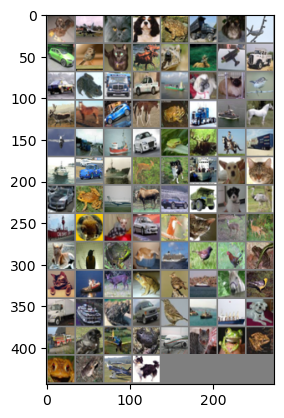

dog   plane cat   dog   frog  truck cat   plane car   bird  cat   deer  frog  deer  plane truck car   frog  truck car   ship  dog   cat   bird  deer  horse car   horse frog  truck ship  horse plane truck ship  car   frog  deer  horse truck ship  car   ship  deer  dog   ship  dog   cat   car   frog  plane deer  car   truck dog   bird  ship  bird  dog   car   bird  cat   deer  deer  horse bird  frog  cat   ship  bird  bird  frog  cat   ship  deer  frog  bird  ship  horse bird  truck ship  frog  car   bird  ship  ship  dog   truck dog   plane frog  plane cat   frog  frog  frog  frog  plane dog  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
images.shape

torch.Size([100, 3, 32, 32])

# Define Utilities

In [5]:
from utils.model import patch_to_image
from utils.datasets import make_patches
import time
def soft_thresholding(x, gamma):
    return torch.sign(x) * torch.max(torch.abs(x) - gamma, torch.zeros_like(x))

def ISTA(img, C, lr, gamma=1, n_steps=100, spa=None):
    # initialize x
    #x = torch.zeros((1,3,4,300,1))
    x = C.transpose(-1,-2) @ img
    loss_list = []
    for i in range(n_steps):
        x = x+lr * C.transpose(-1,-2) @ (img-C @ x)
        x = soft_thresholding(x, gamma*lr)
        loss = torch.norm(img - C @ x).item()+gamma * torch.norm(x,1).item()
        loss_list.append(loss)
    return x, C @ x, loss_list


def FISTA(img, C, lr, gamma=1, n_steps=100, spa=None):
    z = C.transpose(-1,-2) @ img
    loss_list = []
    tk = 1
    x_1 = z
    for i in range(n_steps):
        x = z+lr * C.transpose(-1,-2) @ (img-C @ z)
        x = soft_thresholding(x, gamma*lr)
        
        tk_1 = (1+(1+4 * tk**2)**0.5)/2
        z = x + (tk - 1) / tk_1 * (x - x_1)
        x_1 = x
        tk = tk_1
        
        loss = torch.norm(img - C @ x).item()+gamma * torch.norm(x,1).item()
        loss_list.append(loss)
    return x, C @ x, loss_list

def MM(img, C, gamma=1, n_steps=10):
    x = C.transpose(-1,-2) @ img
    loss_list = []
    Cy = x.clone()
    I = torch.eye(C.shape[-2]).unsqueeze(0).unsqueeze(0)
    for i in range(n_steps):
        W_inv = torch.div(torch.abs(x), gamma)
        x = W_inv * Cy - (W_inv.transpose(-1,-2) * C).transpose(-1,-2) @ \
                torch.inverse(I+(C * W_inv.transpose(-1,-2)) @ C.transpose(-1,-2)) @ \
                        ((C * W_inv.transpose(-1,-2)) @ Cy)
        # print(x_k.min(), x_k.max())
        # normalize & shresholding
        x_index = x / torch.norm(x)
        x_index = torch.abs(x_index) < 1e-3
        x[x_index] = 0
        loss = torch.norm(img - C @ x).item()+gamma * torch.norm(x,1).item()
        loss_list.append(loss)
    return x, C @ x, loss_list

In [6]:
C = torch.randn(1, 3, 4, 256, 300)
C = C / C.norm(dim=-2, keepdim=True)

x_ISTA, recon_ISTA, loss_ISTA = ISTA(make_patches(images,16), C, 1e-1, 0.3, 20)
x_FISTA, recon_FISTA, loss_FISTA = FISTA(make_patches(images,16), C, 1e-1, 0.3, 20)
x_mm, recon_mm, loss_mm = MM(make_patches(images,16), C, 0.3, 20)

In [7]:
# get sparsity level
print(torch.sum(torch.abs(x_ISTA) == 0).item() / x_ISTA.numel())
print(torch.sum(torch.abs(x_FISTA) == 0).item() / x_FISTA.numel())
print(torch.sum(torch.abs(x_mm) == 0).item() / x_mm.numel())

0.5912555555555555
0.6753722222222223
0.8042305555555556


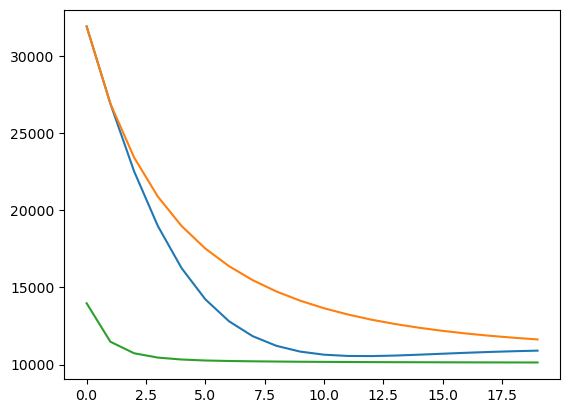

In [8]:
plt.plot(loss_FISTA)
plt.plot(loss_ISTA)
plt.plot(loss_mm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


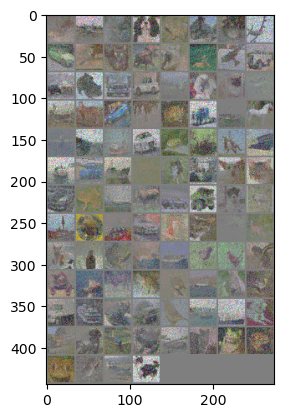

In [9]:
recon_img = patch_to_image(recon_ISTA, 16)

imshow(torchvision.utils.make_grid(recon_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


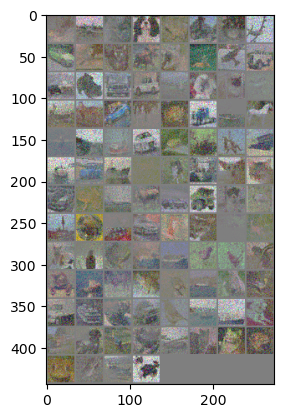

In [10]:
recon_img = patch_to_image(recon_FISTA, 16)

imshow(torchvision.utils.make_grid(recon_img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


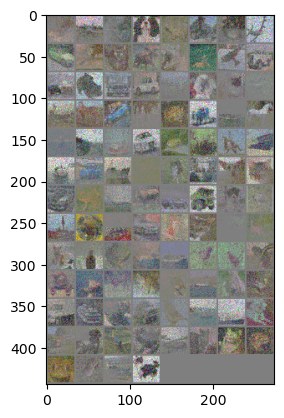

In [11]:
recon_img = patch_to_image(recon_mm, 16)

imshow(torchvision.utils.make_grid(recon_img))

In [14]:
# loop through the entire dataset and record the statistics

loss_all = {'ISTA':[], 'FISTA':[], 'MM':[]}
spa_all = {'ISTA':[], 'FISTA':[], 'MM':[]}

loss_vis_all = {'ISTA':[], 'FISTA':[], 'MM':[]}

for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    x_ISTA, recon_ISTA, loss_ISTA = ISTA(make_patches(inputs,16), C, 1e-2, 0.3, 20)
    x_FISTA, recon_FISTA, loss_FISTA = FISTA(make_patches(inputs, 16), C, 1e-2, 0.3, 20)
    x_mm, recon_mm, loss_mm = MM(make_patches(inputs,16), C, 0.3,20)
    
    loss_all['FISTA'].append(loss_FISTA[-1])
    loss_all['ISTA'].append(loss_ISTA[-1])
    loss_all['MM'].append(loss_mm[-1])
    
    loss_vis_all['FISTA'].append(np.array(loss_FISTA))
    loss_vis_all['ISTA'].append(np.array(loss_ISTA))
    loss_vis_all['MM'].append(np.array(loss_mm))
    
    spa_FISTA = torch.sum(torch.abs(x_FISTA) == 0).item() / x_FISTA.numel()
    spa_ISTA = torch.sum(torch.abs(x_ISTA) == 0).item() / x_ISTA.numel()
    spa_mm = torch.sum(torch.abs(x_mm) == 0).item() / x_mm.numel()
    spa_all['FISTA'].append(spa_FISTA)
    spa_all['ISTA'].append(spa_ISTA)
    spa_all['MM'].append(spa_mm)
    
    #print(f"Sparsity level ISTA: {spa_ISTA}")
    #print(f"Sparsity level FISTA: {spa_FISTA}")
    #print(f"Sparsity level MM: {spa_mm}")
    
    if (i+1) % 10 == 0:
        print(i+1)
    if i == 9:
        print("done")
        break

10
done


In [13]:
print(np.mean(loss_all['ISTA']), np.std(loss_all['ISTA']))
print(np.mean(loss_all['FISTA']), np.std(loss_all['FISTA']))
print(np.mean(loss_all['MM']), np.std(loss_all['MM']))
print()
print(np.mean(spa_all['ISTA']), np.std(spa_all['ISTA']))
print(np.mean(spa_all['FISTA']), np.std(spa_all['FISTA']))
print(np.mean(spa_all['MM']), np.std(spa_all['MM']))

29429.652341003413 586.7070475532402
17741.018079223628 484.7036782549351
11084.660528564451 391.8332362781285

0.0922138888888889 0.0031023159409594102
0.20002555555555554 0.005767604130608085
0.7994077777777777 0.001904626352650282


In [17]:
np.vstack(loss_vis_all['FISTA']).shape

(10, 20)

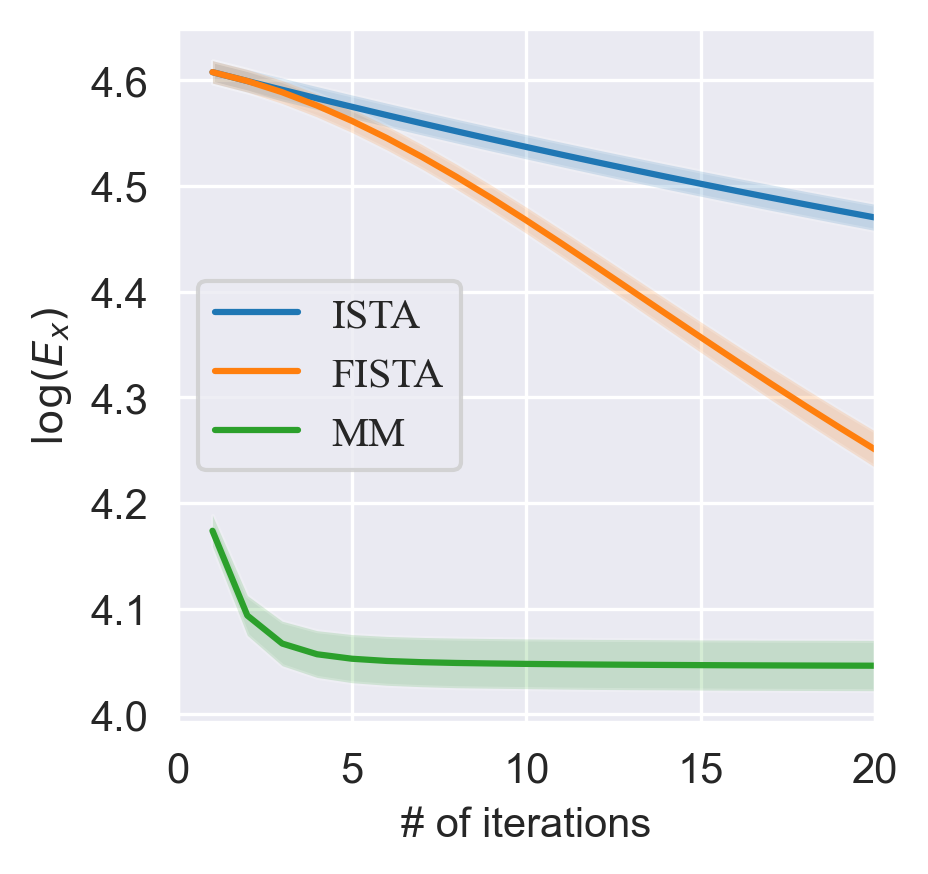

In [38]:
import seaborn as sns
#sns.set_theme(style="whitegrid",palette=None)
# use fonts times new romans
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
sns.set_style("darkgrid")
#sns.set_style("whitegrid")
#sns.lineplot()
x = [i+1 for i in range(20)]
y = np.linspace(6.5, 8.4, 20)
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
x_t = [1,5,10,15,20]
#plt.xticks(x[::4])
#plt.yticks(y[::4])
loss_FISTA = np.vstack(loss_vis_all['FISTA'])
loss_ISTA = np.vstack(loss_vis_all['ISTA'])
loss_MM = np.vstack(loss_vis_all['MM'])
ax.plot(x, np.log10(np.mean(loss_ISTA, axis=0)), label='ISTA')#, linestyle='-', marker='o')
ax.fill_between(x, np.log10(loss_ISTA.min(axis=0)), np.log10(loss_ISTA.max(axis=0)), alpha=0.2)
ax.plot(x, np.log10(np.mean(loss_FISTA, axis=0)), label='FISTA')#, linestyle='-', marker='.')
ax.fill_between(x, np.log10(loss_FISTA.min(axis=0)), np.log10(loss_FISTA.max(axis=0)), alpha=0.2)
ax.plot(x, np.log10(np.mean(loss_MM, axis=0)), label='MM')#, linestyle='-', marker='^')
ax.fill_between(x, np.log10(loss_MM.min(axis=0)), np.log10(loss_MM.max(axis=0)), alpha=0.2)
L=ax.legend()
plt.setp(L.texts, family='Times New Roman')



#plt.setp(ax.patches, linewidth=0)
#plt.xlabel='# of iterations'
#plt.ylabel="$log(E_x)"
x_l = ax.set_xlabel('# of iterations')
y_l = ax.set_ylabel("$\log(E_x)$")

ax.set_xlim([0,20])
#ax.set_ylim([6.4,8.4])
#plt.setp(x_l, family='Times New Roman')
plt.setp(y_l, family='Times New Roman')
plt.show()

# save as pdf
fig.savefig('loss.pdf', dpi=300, bbox_inches='tight')
